In [ ]:
%run -n main.py

In [ ]:
# lines = read_lines('.secret')
# env = dict(parse_dotenv(lines))
# openai.api_key = env['OPENAI_TOKEN']

# tasks

In [ ]:
# table = pd.read_excel('tasks/user_oriented_annot.xlsx')
# table = table[~table.done.isnull()]
# table = table.where(pd.notnull(table), None)

# view = table[['id', 'orig_instruction', 'orig_input']]
# view = view.rename(columns={
#     'orig_instruction': 'instruction',
#     'orig_input': 'input'
# })
# items = view.to_dict(orient='records')
# lines = format_jsonl(items)
# write_lines('tasks/user_oriented_en.jsonl', lines)

# view = table[['id', 'instruction', 'input']]
# items = view.to_dict(orient='records')
# lines = format_jsonl(items)
# write_lines('tasks/user_oriented_ru.jsonl', lines)

In [ ]:
# table = pd.read_excel('tasks/vicuna_question_annot.xlsx')

# view = table[['id', 'category', 'instruction']]
# items = view.to_dict(orient='records')
# lines = format_jsonl(items)
# write_lines('tasks/vicuna_question_ru.jsonl', lines)

# view = table[['id', 'category', 'orig_instruction']]
# view = view.rename(columns={'orig_instruction': 'instruction'})
# items = view.to_dict(orient='records')
# lines = format_jsonl(items)
# write_lines('tasks/vicuna_question_en.jsonl', lines)

# models

## gusev_ru_alpaca_7b_lora

In [ ]:
model_name = 'IlyaGusev/llama_7b_ru_turbo_alpaca_lora'
config = PeftConfig.from_pretrained(model_name)
generation_config = GenerationConfig.from_pretrained(model_name)

tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

model = LlamaForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,

    # Overriding torch_dtype=None with `torch_dtype=torch.float16
    torch_dtype=torch.float16,
    
    # A device map needs to be passed to run convert models into mixed-int8
    device_map='auto'
)
model = PeftModel.from_pretrained(
    model, model_name,
    torch_dtype=torch.float16,
).eval()

## gusev_ru_alpaca_16b_lora

In [ ]:
model_name = 'IlyaGusev/llama_13b_ru_turbo_alpaca_lora'
config = PeftConfig.from_pretrained(model_name)
generation_config = GenerationConfig.from_pretrained(model_name)

tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

model = LlamaForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
model = PeftModel.from_pretrained(
    model, model_name,
    torch_dtype=torch.float16,
).eval()

## gusev_saiga_7b_lora, 13b

In [ ]:
model_name = 'IlyaGusev/saiga_13b_lora'
config = PeftConfig.from_pretrained(model_name)
generation_config = GenerationConfig.from_pretrained(model_name)
generation_config.max_new_tokens = 512

tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

model = LlamaForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
model = PeftModel.from_pretrained(
    model, model_name,
    torch_dtype=torch.float16,
).eval()

## gusev_ru_alpaca_7b_llamacpp

In [ ]:
home_dir = Path.home()
main_path = home_dir / 'src/llama.cpp/main'
model_path = home_dir / 'models/llama_7b_ru_turbo_alpaca_lora_llamacpp/7B/ggml-model-q4_0.bin'
generation_args = [
    '--top_k', '40',
    '--top_p', '0.9',
    '--repeat_penalty', '1.1',
    '--ctx_size', '256',
    '--n_predict', '512',
    '--temp', '0.95'
]

## gusev_alpaca_7b_lora

In [ ]:
model_name = 'IlyaGusev/alpaca_7b_lora_reproduce'

config = PeftConfig.from_pretrained(model_name)
config.base_model_name_or_path = 'decapoda-research/llama-7b-hf'

tokenizer = LlamaTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'

model = LlamaForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
model = PeftModel.from_pretrained(
    model, model_name,
    torch_dtype=torch.float16,
).eval()

## gusev_fred

In [ ]:
%run -n main.py
model_name = 'IlyaGusev/fred_t5_ru_turbo_alpaca'
tokenizer = AutoTokenizer.from_pretrained(model_name)

generation_config = GenerationConfig.from_pretrained(model_name)
generation_config.max_new_tokens = 512

device = 'cuda:0'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.to(device).eval()

## chainyo_alpaca_7b_lora

In [ ]:
model_name = 'chainyo/alpaca-lora-7b'
tokenizer = LlamaTokenizer.from_pretrained(model_name)
generation_config = GenerationConfig(
    temperature=0.2,
    top_p=0.75,
    top_k=40,
    num_beams=4,
    max_new_tokens=128,
)
model = LlamaForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto',
).eval()

## wortega_instruct_rugpt_large

In [ ]:
model_name = 'AlexWortega/instruct_rugptlarge'

tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
special_tokens_dict = {
    'additional_special_tokens': [
        '<code>', '</code>',
        '<instructionS>', '<instructionE>',
        '<next>'
    ]
}
tokenizer.add_special_tokens(special_tokens_dict)

generation_config = GenerationConfig(
    min_length=20,
    max_new_tokens=512,
    top_k=50,
    top_p=0.7,
    do_sample=True,  
    early_stopping=True,
    no_repeat_ngram_size=2,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    use_cache=True,
    repetition_penalty=1.5,  
    length_penalty=1.2,  
    num_beams=4,
)

device = 'cuda:0'
model = GPT2LMHeadModel.from_pretrained(model_name).to(device).eval()
model.resize_token_embeddings(len(tokenizer))

## oasst_pythia

In [ ]:
%run -n main.py
model_name = 'OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5'

tokenizer = AutoTokenizer.from_pretrained(model_name)

generation_config = GenerationConfig.from_pretrained(model_name)
generation_config.max_new_tokens = 512
generation_config.repetition_penalty = 1.1
generation_config.no_repeat_ngram_size = 8

device = 'cuda:0'
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to(device).eval()

# evals

In [ ]:
task_path = Path('tasks/vicuna_question_ru.jsonl')
eval_path = Path('evals/vicuna_question_ru/oasst_pythia.jsonl')

In [ ]:
%run -n main.py
task_records = load_task(task_path)
eval_records = [
    EvalRecord(
        id=_.id,
        prompt=oasst_prompt(_),
        output=None
    )
    for _ in task_records
]
random.sample(eval_records, 10)

In [ ]:
dump_eval(eval_path, eval_records)

In [ ]:
%run -n main.py
eval_records = list(load_eval(eval_path))

In [ ]:
total = len(eval_records)
have_output = sum(
    _.output is not None
    for _ in eval_records
)
print(have_output, total)

In [ ]:
%run -n main.py
model_batch_complete(eval_records, model, tokenizer, generation_config, batch_size=8)

In [ ]:
for record in eval_records:
    if record.output is None:
        continue

    prompt = re.sub(r'<\|.+?\|>', '', record.prompt)
    output = record.output.removeprefix(prompt)
#     # output = output[:output.find('<end>')]
#     print(output)
#     print('\n\n\n')

    record.output = output

In [ ]:
# %run -n main.py
# await batch_llamacpp_complete(
#     eval_records, main_path, model_path, generation_args,
#     threads=8, pool_size=3
# )

In [ ]:
%run -n main.py
dump_eval(eval_path, eval_records)

# annot

In [16]:
%run -n main.py
task = 'vicuna_question_ru'
a_name = 'openai_davinci_003'
b_name = 'gusev_saiga_13b_lora'

lines = read_lines(f'evals/{task}/{a_name}.jsonl')
a_items = list(parse_jsonl(lines))

lines = read_lines(f'evals/{task}/{b_name}.jsonl')
b_items = list(parse_jsonl(lines))

In [17]:
import pandas as pd

id_a_items = {_['id']: _ for _ in a_items}
id_b_items = {_['id']: _ for _ in b_items}
items = []
for id in sorted(id_a_items.keys() & id_b_items.keys()):
    a_item = id_a_items[id]
    b_item = id_b_items[id]

    items.append({
        'id': id,
        'prompt': b_item['prompt'],
        'a': a_item['output'],
        'b': b_item['output'],
        'label': None
    })

table = pd.DataFrame(items)
table.to_excel(f'sbs/{task}/{a_name}_{b_name}.xlsx', index=False)

# report

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
+ gusev_fred
+ oasst_pythia

+ wortega_instruct_rugpt_large
wortega_instruct_rugpt_large_v2

+ gusev_ru_alpaca_7b_lora
gusev_ru_alpaca_7b_lora_v2

. gusev_ru_alpaca_13b_lora
gusev_ru_alpaca_13b_lora_v2

+ gusev_saiga_7b_lora
gusev_saiga_7b_lora_v2

. gusev_saiga_13b_lora
gusev_saiga_30b_lora

+ davinci-002
. turbo

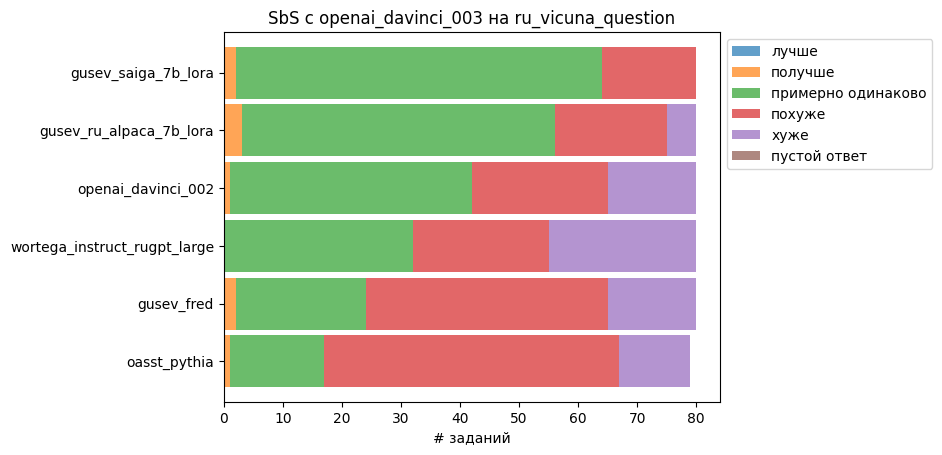

In [62]:
from pathlib import Path

names = [
#     'openai_turbo',
    'gusev_saiga_7b_lora',
    'gusev_ru_alpaca_7b_lora',
    'openai_davinci_002',
    'wortega_instruct_rugpt_large',
    'gusev_fred',
    'oasst_pythia',
]


data = {}
for name in names:
    path = f'sbs/vicuna_question_ru/openai_davinci_003_{name}.xlsx'
    table = pd.read_excel(path, dtype='str')
    
    label_counts = table.label.value_counts()
    for label, count in label_counts.items():
        data[name, label] = count
        

table = pd.Series(data)
table = table.unstack()
table = table.fillna(0)

table = table.reindex(
    index=reversed(names),
    columns=[
        '2', '1', '0', '-1', '-2', '?',
    ]
    
)
table = table.rename(
    columns = {
        '?': 'пустой ответ',
        '-2': 'хуже',
        '-1': 'похуже',
        '0': 'примерно одинаково',
        '1': 'получше',
        '2': 'лучше'
    }
)


table.plot(
    title='SbS с openai_davinci_003 на ru_vicuna_question',
    kind='barh',
    stacked=True,
    width=0.9,
    alpha=0.7,
    xlabel='# заданий'
).legend(
    loc='upper left',
    bbox_to_anchor=(1.0, 1.0)
)

In [ ]:
!open sbs